<a name='0_0'></a>
# <span style="color:#ff5f27">👨🏻‍🏫 AutoEncoders </span>

🗄️ Table of Contents:

- [📝 Imports](#0)
- [👨🏻‍🍳 Data Preparation](#1)
- [⚙️ Reconstruction AutoEncoder Architecture](#2)
    - [👩🏻‍🔬 Experiments with Architecture](#21)
- [⚙️ Denoising AutoEncoder Architecture](#3)
    - [🧖🏻‍♂️ 🧬 Salt and Pepper Noise](#31)
    - [🔪 Image Cutout](#32)
    - [👩🏻‍🔬 Experiments with Noise](#4)
- [👩🏻‍🔬 Experiments with Architectures](#5)

<a name='0'></a>
## <span style="color:#ff5f27">📝 Imports </span>

In [1]:
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
from tensorflow.random import set_seed
import imgaug.augmenters as iaa

2023-10-18 20:06:39.280919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='1'></a>

## <span style="color:#ff5f27">👨🏻‍🍳 Data Preparation </span>

In [2]:
train = pd.read_csv("data/fashion-mnist_train.csv")
train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


In [3]:
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

In [4]:
train_x = train_x / 255

train_x, val_x, train_y, val_y = train_test_split(
    train_x, 
    train_y, 
    test_size=0.2,
)
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

<a name='2'></a>
## <span style="color:#ff5f27">⚙️ Reconstruction AutoEncoder Architecture </span>

In [5]:
def reset_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value) 
    random.seed(seed_value)
    set_seed(seed_value)

In [6]:
def compare_images(X, model, task, num_images=5):
    fig, ax = plt.subplots(2, num_images, figsize=(10, 4))

    for i in range(num_images):
        ax[0, i].imshow(X[i].reshape(28, 28))
        ax[1, i].imshow(model.predict(X[i:i+1]).reshape(28, 28))
        
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        
    if task == 'denoising':
        fig.suptitle("Noisy and Denoised Images")
    elif task == 'reconstruction':
        fig.suptitle("Original and Reconstructed Images")
        
    plt.show()

In [7]:
def plot_loss(history, scores_df, model_name):
    
    train_loss = history.history["loss"][-1]
    val_loss = history.history["val_loss"][-1]

    new_scores_df = pd.DataFrame(
        {
            'model_name': [model_name], 
            'train_loss': [train_loss], 
            'val_loss': [val_loss],
        }
    )
    scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)
    
    print(f'🎯 Train Accuracy: {train_loss}')
    print(f'🎯 Val Accuracy: {val_loss}')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    ax.plot(history.history['loss'], label="train loss")
    ax.plot(history.history['val_loss'], label="validation loss")
    ax.set_title("Loss")
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

    plt.show()
    
    return scores_df

In [8]:
TASK = 'reconstruction'

scores_df_reconstruction = pd.DataFrame(columns=['model_name', 'train_loss', 'val_loss'])
scores_df_reconstruction

,model_name,train_loss,val_loss


<a name='21'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Experiments with Architecture </span>
- [🗄️ Table of Contents](#0_0)

In [9]:
reset_seeds()
input_layer = Input(shape=(28*28,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer = Dense(28*28)(decode_layer3)
model_default = Model(input_layer, output_layer)

2023-10-18 20:06:55.669975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model_default.compile(
    optimizer='adam',
    loss='mse'
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    mode='auto',
)

history_default = model_default.fit(
    train_x, 
    train_x, 
    epochs=50, 
    batch_size=2048, 
    validation_data=(val_x, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

/var/folders/jc/bcd0px_d09v6ph36k1s810sw0000gn/T/ipykernel_9129/4165819854.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)


🎯 Train Accuracy: 0.013558770529925823
🎯 Val Accuracy: 0.013757528737187386


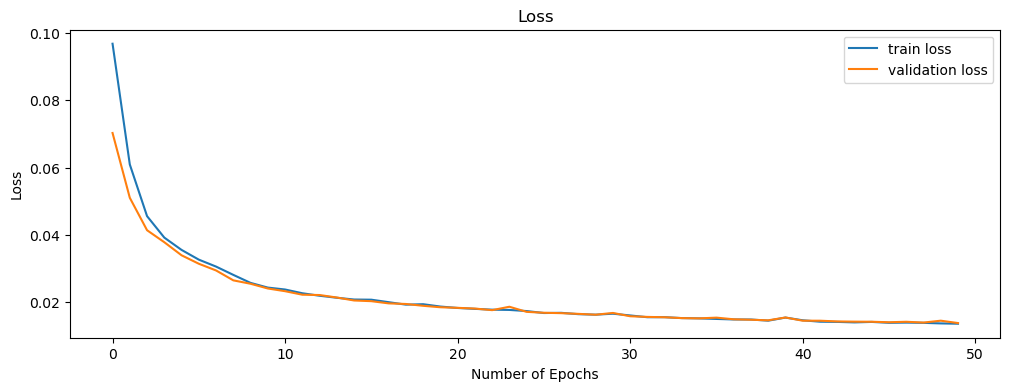

In [11]:
scores_df_reconstruction = plot_loss(
    history_default, 
    scores_df_reconstruction, 
    '1500,1000,500 | 10',
)

1/1 [==============================] - 0s 18ms/step


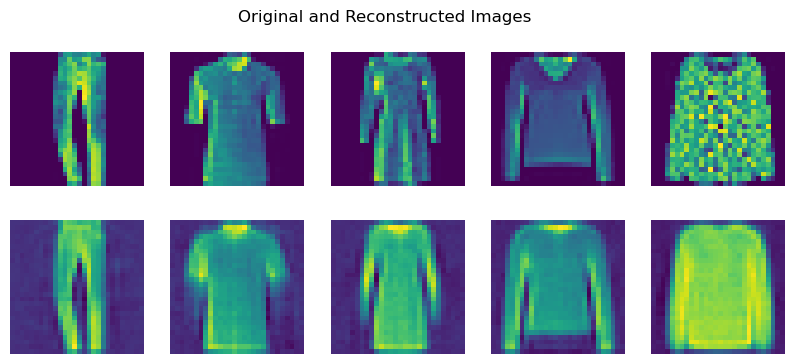

In [12]:
compare_images(val_x, model_default, TASK)

In [13]:
reset_seeds()
input_layer = Input(shape=(28 * 28,))

## encoding architecture
encode_layer = Dense(2048, activation='relu')(input_layer)
encode_layer = Dense(1024, activation='relu')(encode_layer)
encode_layer = Dense(512, activation='relu')(encode_layer)
encode_layer = Dense(256, activation='relu')(encode_layer)

## latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer)

## decoding architecture
decode_layer = Dense(256, activation='relu')(latent_view)
decode_layer = Dense(512, activation='relu')(decode_layer)
decode_layer = Dense(1024, activation='relu')(decode_layer)
decode_layer = Dense(2048, activation='relu')(decode_layer)

## output layer
output_layer = Dense(28*28)(decode_layer)

In [14]:
model_complex = Model(input_layer, output_layer)

model_complex.compile(
    optimizer='adam',
    loss='mse',
)

In [15]:
history_complex = model_complex.fit(
    train_x,
    train_x,
    epochs=50, 
    batch_size=2048, 
    validation_data=(val_x, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.014818256720900536
🎯 Val Accuracy: 0.014904927462339401


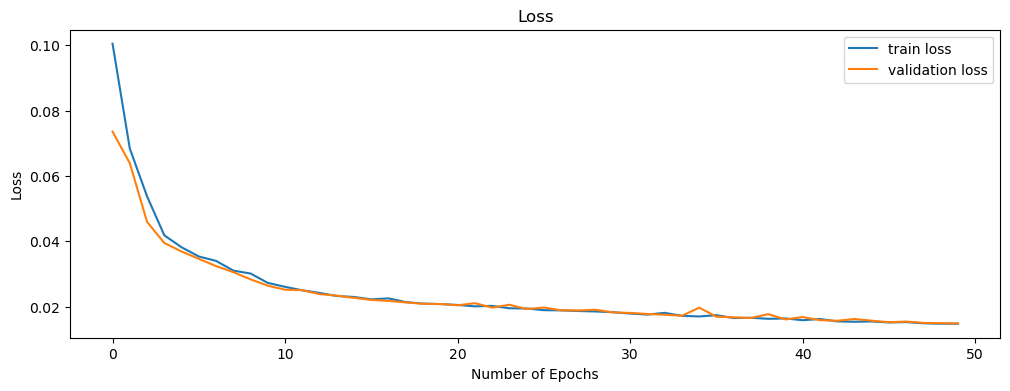

In [16]:
scores_df_reconstruction = plot_loss(
    history_complex, 
    scores_df_reconstruction, 
    '2^8 -> 2^11 | 10',
)

1/1 [==============================] - 0s 20ms/step


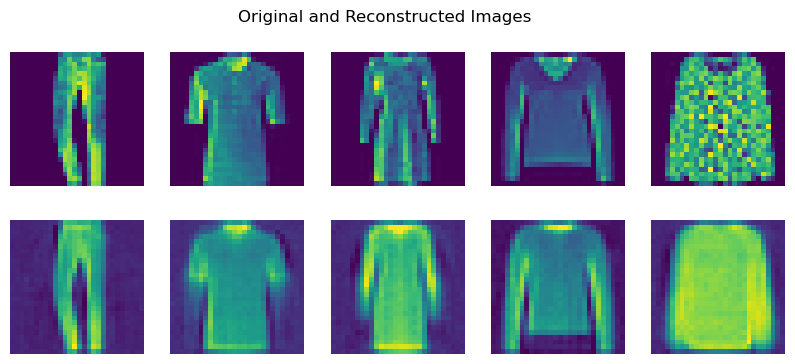

In [17]:
compare_images(val_x, model_complex, TASK)

In [18]:
reset_seeds()
input_layer = Input(shape=(28 * 28,))

## encoding architecture
encode_layer = Dense(1024, activation='relu')(input_layer)
encode_layer = Dense(512, activation='relu')(encode_layer)
encode_layer = Dense(256, activation='relu')(encode_layer)
encode_layer = Dense(128, activation='relu')(encode_layer)

## latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer)

## decoding architecture
decode_layer = Dense(128, activation='relu')(latent_view)
decode_layer = Dense(256, activation='relu')(decode_layer)
decode_layer = Dense(512, activation='relu')(decode_layer)
decode_layer = Dense(1024, activation='relu')(decode_layer)

## output layer
output_layer = Dense(28*28)(decode_layer)

In [19]:
model_simple = Model(input_layer, output_layer)

model_simple.compile(
    optimizer='adam',
    loss='mse',
)

In [20]:
history_simple = model_simple.fit(
    train_x,
    train_x,
    epochs=50, 
    batch_size=2048, 
    validation_data=(val_x, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.015097022987902164
🎯 Val Accuracy: 0.01515374518930912


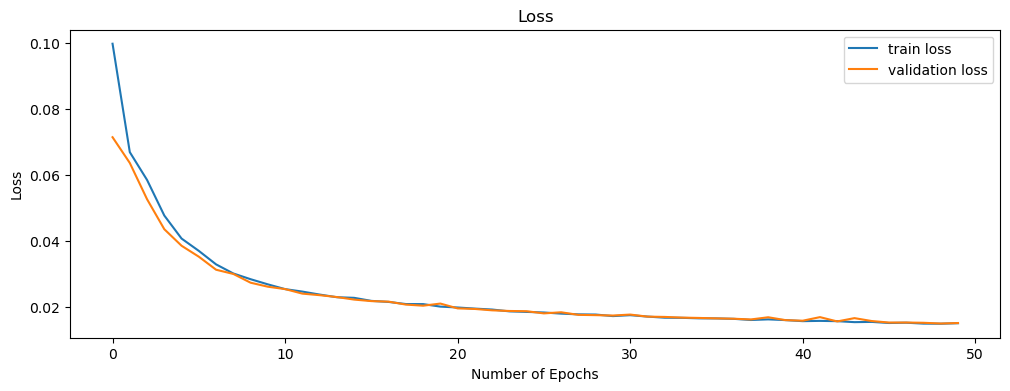

In [21]:
scores_df_reconstruction = plot_loss(
    history_simple, 
    scores_df_reconstruction, 
    '2^7 -> 2^10 | 10',
)

1/1 [==============================] - 0s 18ms/step


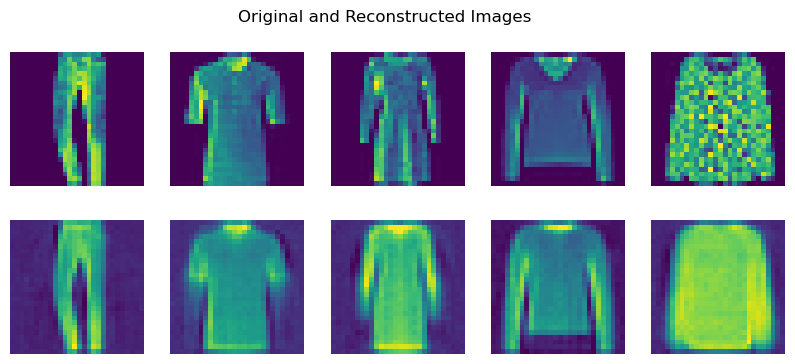

In [22]:
compare_images(val_x, model_complex, TASK)

In [23]:
scores_df_reconstruction

,model_name,train_loss,val_loss
0,"1500,1000,500 | 10",0.013559,0.013758
1,2^8 -> 2^11 | 10,0.014818,0.014905
2,2^7 -> 2^10 | 10,0.015097,0.015154


In [24]:
reset_seeds()
input_layer = Input(shape=(28 * 28,))

## encoding architecture
encode_layer = Dense(1500, activation='relu')(input_layer)
encode_layer = BatchNormalization()(encode_layer)
encode_layer = Dense(1000, activation='relu')(encode_layer)
encode_layer = BatchNormalization()(encode_layer)
encode_layer = Dense(500, activation='relu')(encode_layer)

## latent view
latent_view = Dense(10, activation='sigmoid')(encode_layer)

## decoding architecture
decode_layer = Dense(500, activation='relu')(latent_view)
decode_layer = BatchNormalization()(decode_layer)
decode_layer = Dense(1000, activation='relu')(decode_layer)
encode_layer = BatchNormalization()(encode_layer)
decode_layer = Dense(1500, activation='relu')(decode_layer)

## output layer
output_layer = Dense(28*28)(decode_layer)

In [25]:
model_batch_norm = Model(input_layer, output_layer)

model_batch_norm.compile(
    optimizer='adam',
    loss='mse',
)

In [26]:
history_batch_norm = model_batch_norm.fit(
    train_x,
    train_x,
    epochs=50, 
    batch_size=2048, 
    validation_data=(val_x, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.01294409204274416
🎯 Val Accuracy: 0.013792208395898342


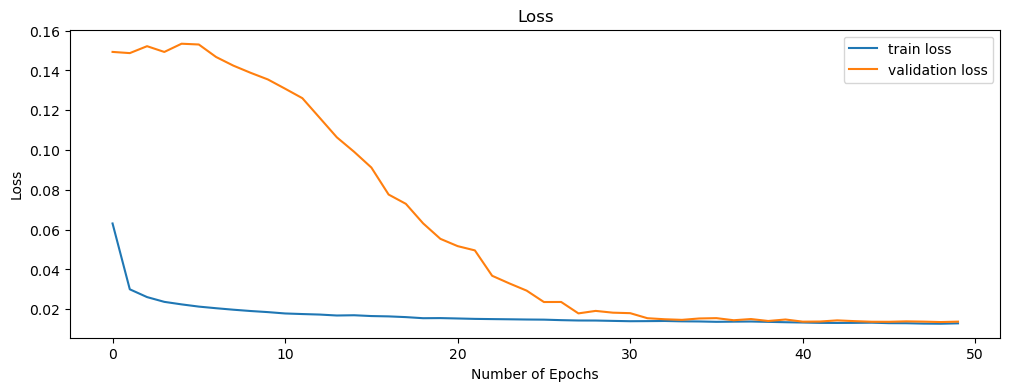

In [27]:
scores_df_reconstruction = plot_loss(
    history_batch_norm, 
    scores_df_reconstruction, 
    '1500,1000,500 | 10 BatchNorm',
)

1/1 [==============================] - 0s 19ms/step


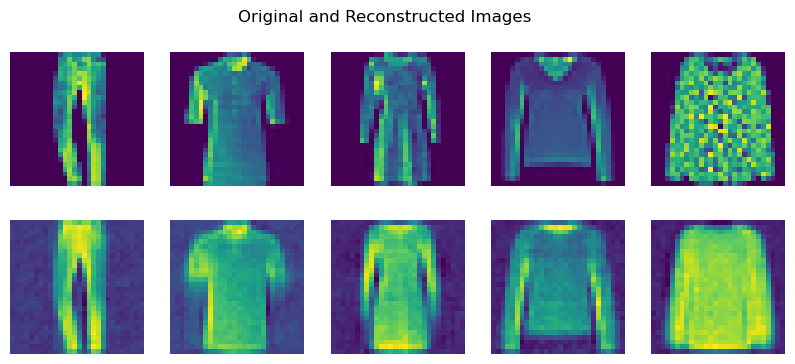

In [28]:
compare_images(val_x, model_batch_norm, TASK)

In [29]:
reset_seeds()
input_layer = Input(shape=(28 * 28,))

## encoding architecture
encode_layer = Dense(1500, activation='relu')(input_layer)
encode_layer = BatchNormalization()(encode_layer)
encode_layer = Dense(1000, activation='relu')(encode_layer)
encode_layer = BatchNormalization()(encode_layer)
encode_layer = Dense(500, activation='relu')(encode_layer)

## latent view
latent_view = Dense(20, activation='sigmoid')(encode_layer)

## decoding architecture
decode_layer = Dense(500, activation='relu')(latent_view)
decode_layer = BatchNormalization()(decode_layer)
decode_layer = Dense(1000, activation='relu')(decode_layer)
encode_layer = BatchNormalization()(encode_layer)
decode_layer = Dense(1500, activation='relu')(decode_layer)

## output layer
output_layer = Dense(28*28)(decode_layer)

In [30]:
model_bn_latent20 = Model(input_layer, output_layer)

model_bn_latent20.compile(
    optimizer='adam',
    loss='mse',
)

In [31]:
history_bn_latent20 = model_bn_latent20.fit(
    train_x,
    train_x,
    epochs=50, 
    batch_size=2048, 
    validation_data=(val_x, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.01094044465571642
🎯 Val Accuracy: 0.01157361175864935


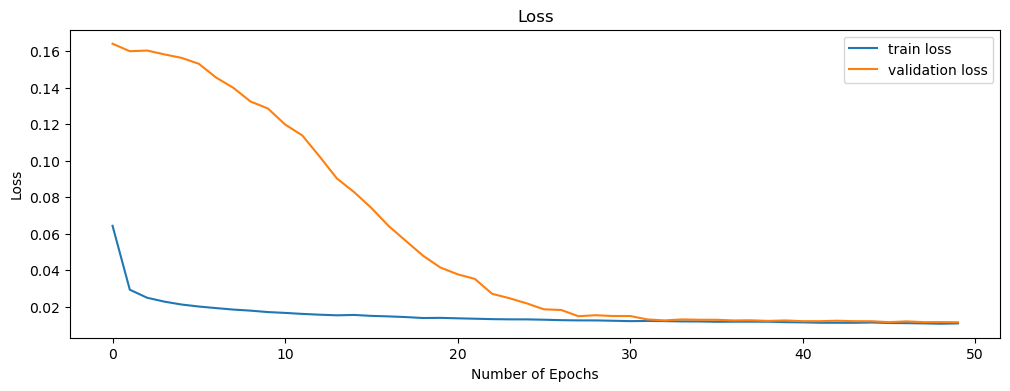

In [32]:
scores_df_reconstruction = plot_loss(
    history_bn_latent20, 
    scores_df_reconstruction, 
    '1500,1000,500 | 20 BatchNorm',
)

1/1 [==============================] - 0s 16ms/step


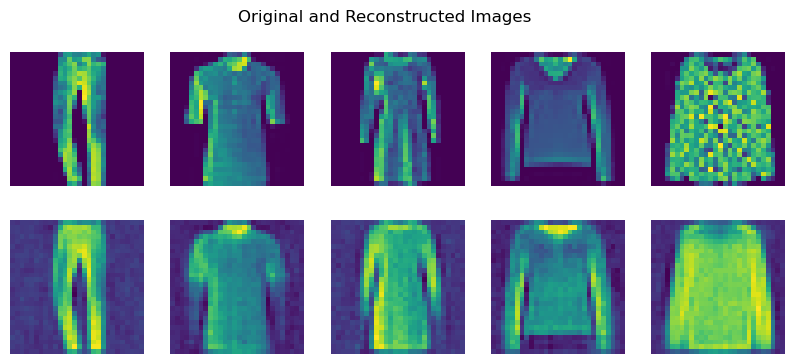

In [33]:
compare_images(val_x, model_bn_latent20, TASK)

In [34]:
scores_df_reconstruction

,model_name,train_loss,val_loss
0,"1500,1000,500 | 10",0.013559,0.013758
1,2^8 -> 2^11 | 10,0.014818,0.014905
2,2^7 -> 2^10 | 10,0.015097,0.015154
3,"1500,1000,500 | 10 BatchNorm",0.012944,0.013792
4,"1500,1000,500 | 20 BatchNorm",0.010940,0.011574


---
<a name='3'></a>
## <span style="color:#ff5f27">⚙️ Denoising AutoEncoder Architecture </span>
- [🗄️ Table of Contents](#0_0)

In [35]:
def add_noise(X, noise_level, show=False):
    
    noise_sap = augmenters.SaltAndPepper(noise_level/100) 
    
    seq_object = augmenters.Sequential([noise_sap])

    X_sap = seq_object.augment_images(X * 255) / 255
    
    if show:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))

        for i in range(5):
            ax[0, i].imshow(X[i].reshape(28, 28))
            ax[1, i].imshow(X_sap[i].reshape(28, 28))
            ax[0, i].axis('off')
            ax[1, i].axis('off')

        ax[0, 2].set_title("Original Images", loc='center')
        ax[1, 2].set_title(f"Noisy Images {noise_level}%", loc='center')

        plt.show()
        
    return X_sap

In [36]:
def add_cutout(X, nb_iterations=10, show=False):
    
    cutout = iaa.Cutout(nb_iterations)
    
    seq_object = augmenters.Sequential([cutout])

    X_cutout = seq_object.augment_images(X * 255) / 255
    
    if show:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))

        for i in range(5):
            ax[0, i].imshow(X[i].reshape(28, 28))
            ax[1, i].imshow(X_cutout[i].reshape(28, 28))
            ax[0, i].axis('off')
            ax[1, i].axis('off')

        ax[0, 2].set_title("Original Images", loc='center')
        ax[1, 2].set_title(f"Images with Cutout", loc='center')

        plt.show()
        
    return X_cutout

In [37]:
TASK = 'denoising'

scores_df_denoising = pd.DataFrame(columns=['model_name', 'train_loss', 'val_loss'])
scores_df_denoising

,model_name,train_loss,val_loss


### <span style="color:#ff5f27">👨🏻‍🍳 Data Preparation </span>

In [38]:
train_x = train[list(train.columns)[1:]].values

train_x, val_x = train_test_split(
    train_x, 
    test_size=0.2,
)

In [39]:
train_x = train_x / 255
val_x = val_x / 255

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

<a name='31'></a>
### <span style="color:#ff5f27">🧖🏻‍♂️ 🧬 SaltAndPepper Noise </span>
- [🗄️ Table of Contents](#0_0)

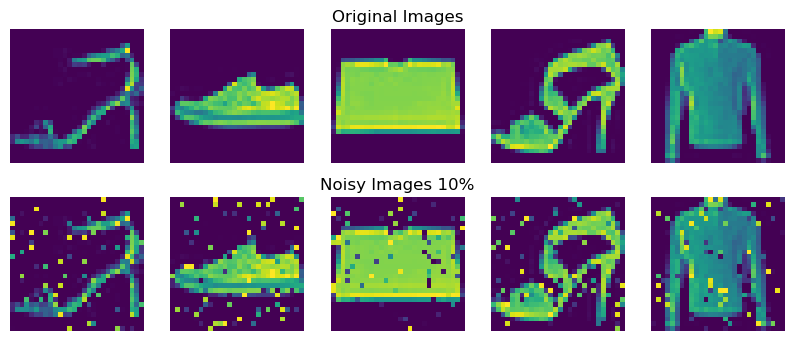

In [40]:
train_x_sap10 = add_noise(train_x, 10, True)
val_x_sap10 = add_noise(val_x, 10)

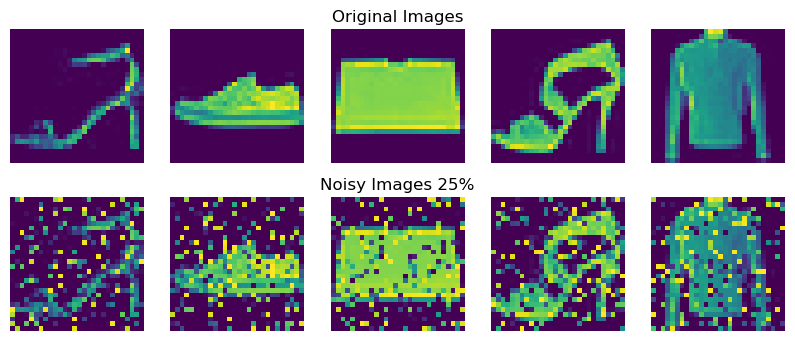

In [41]:
train_x_sap25 = add_noise(train_x, 25, True)
val_x_sap25 = add_noise(val_x, 25)

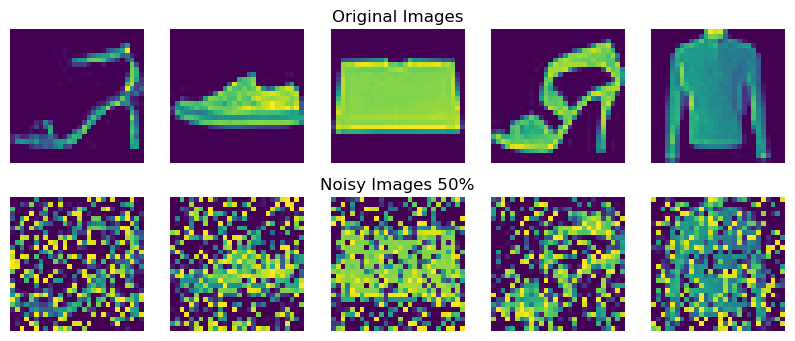

In [42]:
train_x_sap50 = add_noise(train_x, 50, True)
val_x_sap50 = add_noise(val_x, 50)

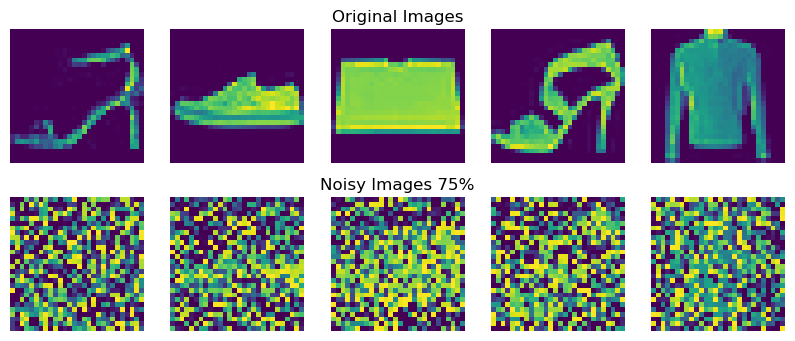

In [43]:
train_x_sap75 = add_noise(train_x, 75, True)
val_x_sap75 = add_noise(val_x, 75)

<a name='32'></a>
### <span style="color:#ff5f27">🔪 Image Cutout </span>
- [🗄️ Table of Contents](#0_0)

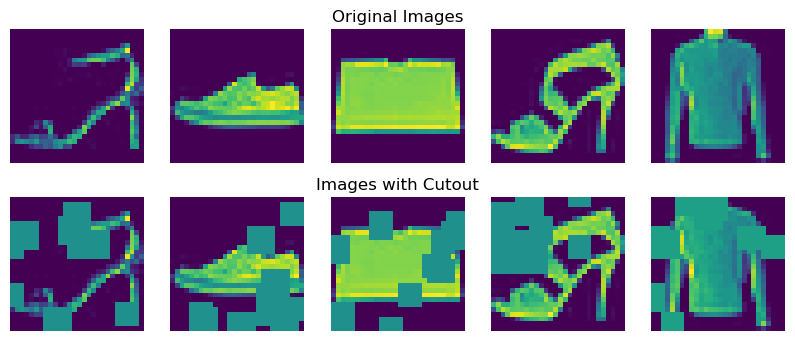

In [44]:
train_x_cutout = add_cutout(train_x, show=True)
val_x_cutout = add_cutout(val_x)

<a name='4'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Experiments with Noise</span>
- [🗄️ Table of Contents](#0_0)

In [45]:
def create_model():
    reset_seeds()
    input_layer = Input(shape=(28, 28, 1))

    # encoding architecture
    encoder_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoder_layer = MaxPool2D( (2, 2), padding='same')(encoder_layer)
    encoder_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_layer)
    encoder_layer = MaxPool2D( (2, 2), padding='same')(encoder_layer)
    encoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_layer)

    # latent view
    latent_view = MaxPool2D((2, 2), padding='same')(encoder_layer)

    # decoding architecture
    decoder_layer = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    decoder_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    decoder_layer = Conv2D(64, (3, 3), activation='relu')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    output_layer = Conv2D(1, (3, 3), padding='same')(decoder_layer)

    # compile the model
    model = Model(input_layer, output_layer)

    model.compile(
        optimizer='adam', 
        loss='mse',
    )
    
    return model

In [46]:
model_sap10 = create_model()

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=5, 
    mode='auto',
)

In [47]:
history_sap10 = model_sap10.fit(
    train_x_sap10, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap10, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.019866211339831352
🎯 Val Accuracy: 0.01936323009431362


/var/folders/jc/bcd0px_d09v6ph36k1s810sw0000gn/T/ipykernel_9129/4165819854.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)


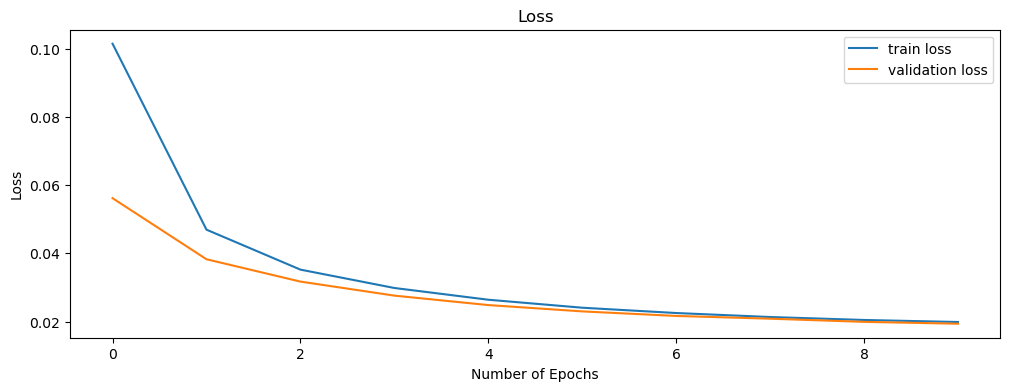

In [48]:
scores_df_denoising = plot_loss(
    history_sap10, 
    scores_df_denoising, 
    'SAP10',
)

1/1 [==============================] - 0s 18ms/step


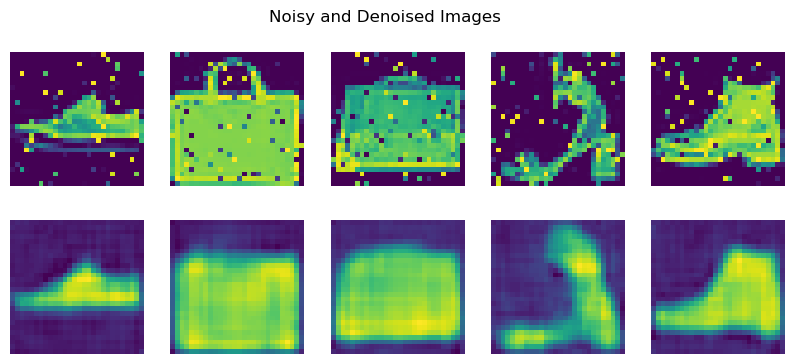

In [49]:
compare_images(val_x_sap10, model_sap10, TASK)

In [50]:
model_sap25 = create_model()

history_sap25 = model_sap25.fit(
    train_x_sap25, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap25, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.021686607971787453
🎯 Val Accuracy: 0.021350814029574394


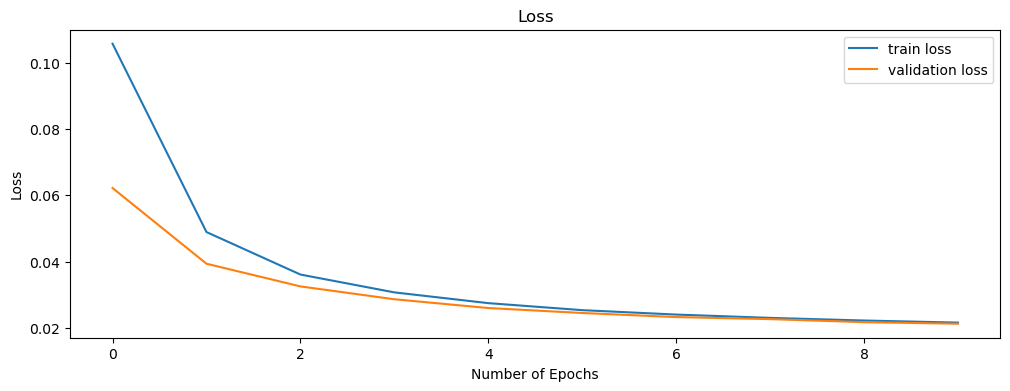

In [51]:
scores_df_denoising = plot_loss(
    history_sap25, 
    scores_df_denoising, 
    'SAP25',
)

1/1 [==============================] - 0s 19ms/step


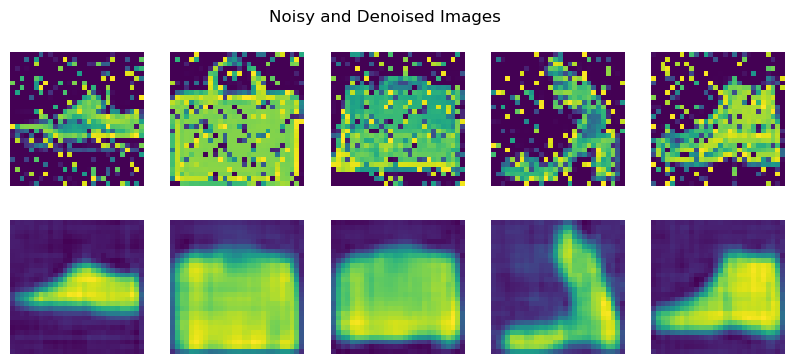

In [52]:
compare_images(val_x_sap25, model_sap25, TASK)

In [53]:
scores_df_denoising

,model_name,train_loss,val_loss
0,SAP10,0.019866,0.019363
1,SAP25,0.021687,0.021351


In [54]:
model_sap50 = create_model()

history_sap50 = model_sap50.fit(
    train_x_sap50, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap50, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.026456832885742188
🎯 Val Accuracy: 0.026014413684606552


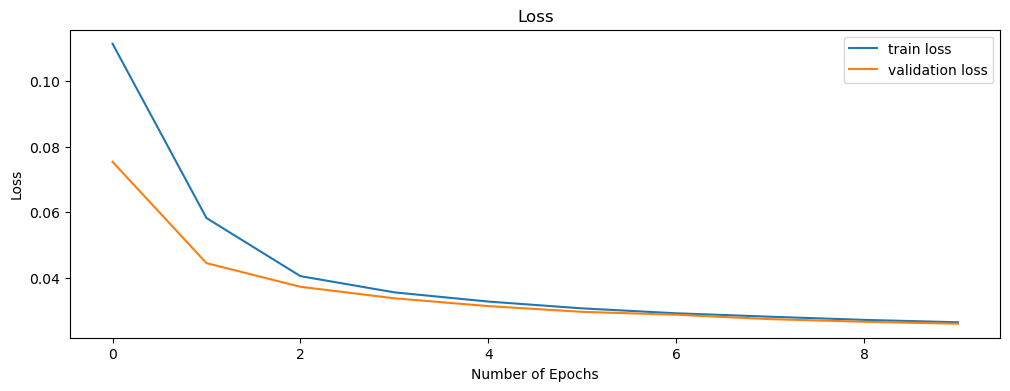

In [55]:
scores_df_denoising = plot_loss(
    history_sap50, 
    scores_df_denoising, 
    'SAP50',
)

1/1 [==============================] - 0s 17ms/step


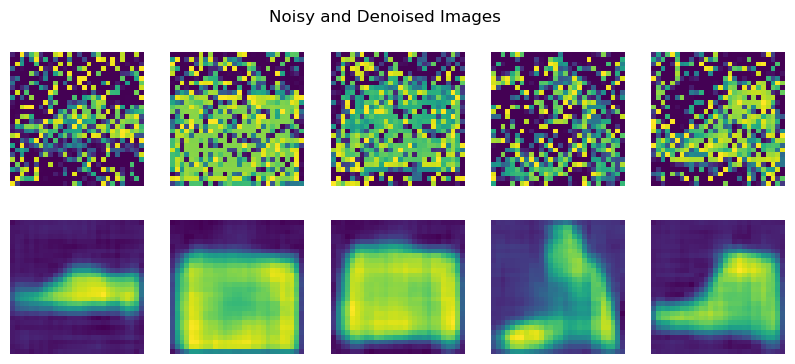

In [56]:
compare_images(val_x_sap50, model_sap50, TASK)

In [57]:
model_sap75 = create_model()

history_sap75 = model_sap75.fit(
    train_x_sap75, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap75, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.03849947452545166
🎯 Val Accuracy: 0.03756396844983101


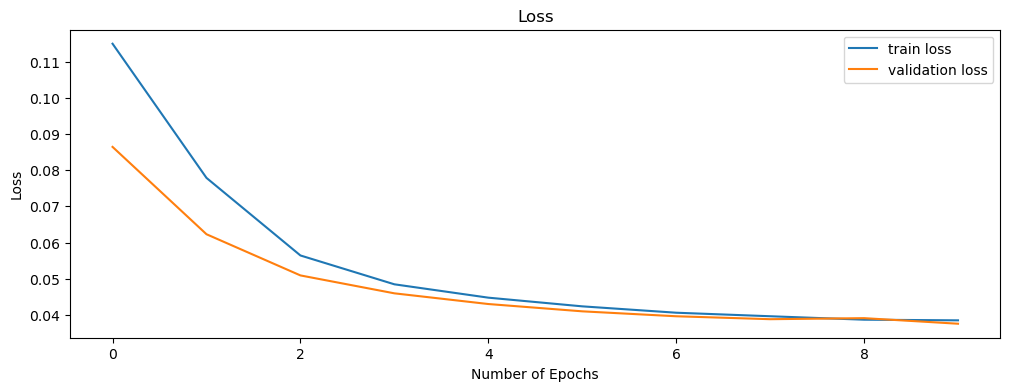

In [58]:
scores_df_denoising = plot_loss(
    history_sap75, 
    scores_df_denoising, 
    'SAP75',
)

1/1 [==============================] - 0s 26ms/step


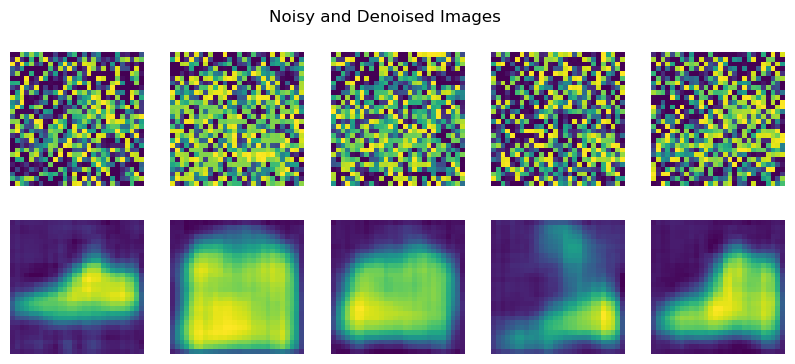

In [59]:
compare_images(val_x_sap75, model_sap75, TASK)

In [60]:
scores_df_denoising

,model_name,train_loss,val_loss
0,SAP10,0.019866,0.019363
1,SAP25,0.021687,0.021351
2,SAP50,0.026457,0.026014
3,SAP75,0.038499,0.037564


In [61]:
model_cutout = create_model()

history_cutout = model_cutout.fit(
    train_x_cutout, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_cutout, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.02573563903570175
🎯 Val Accuracy: 0.025286996737122536


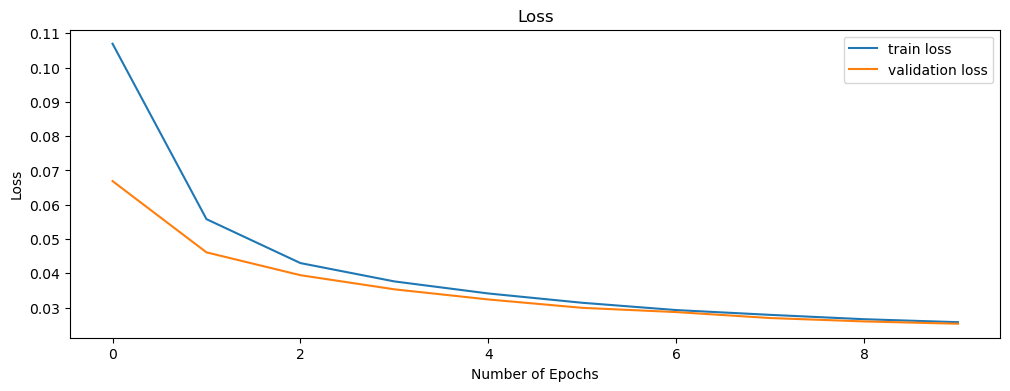

In [62]:
scores_df_denoising = plot_loss(
    history_cutout, 
    scores_df_denoising, 
    'Cutout',
)

1/1 [==============================] - 0s 17ms/step


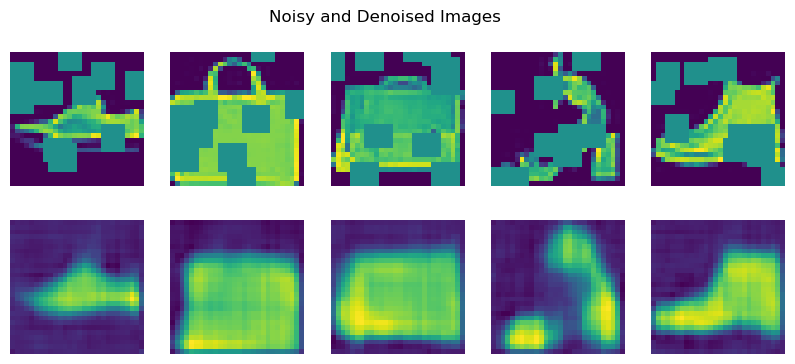

In [63]:
compare_images(val_x_cutout, model_cutout, TASK)

In [64]:
scores_df_denoising

,model_name,train_loss,val_loss
0,SAP10,0.019866,0.019363
1,SAP25,0.021687,0.021351
2,SAP50,0.026457,0.026014
3,SAP75,0.038499,0.037564
4,Cutout,0.025736,0.025287


<a name='5'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Experiments with Architecture </span>
- [🗄️ Table of Contents](#0_0)

In [65]:
def compare_models(X, model1, model2, num_images=5):
    fig, ax = plt.subplots(3, num_images, figsize=(10, 6))

    for i in range(num_images):
        ax[0, i].imshow(X[i].reshape(28, 28))
        ax[1, i].imshow(model1.predict(X[i:i+1]).reshape(28, 28))
        ax[2, i].imshow(model2.predict(X.reshape(-1, 784)[i:i+1]).reshape(28, 28))
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

    fig.suptitle("Comparison of Convolutional and Deep AutoEncoders")

    plt.show()

### <span style="color:#ff5f27">⚙️ Convolutional AutoEncoder on SAP50 </span>

In [66]:
def get_convolutional_autoencoder():
    reset_seeds()
    # Input layer
    input_layer = Input(shape=(28, 28, 1))

    encoder_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    encoder_layer = MaxPool2D( (2, 2), padding='same')(encoder_layer)
    encoder_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_layer)
    encoder_layer = MaxPool2D( (2, 2), padding='same')(encoder_layer)
    encoder_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_layer)

    # Latent view
    latent_view = MaxPool2D((2, 2), padding='same')(encoder_layer)

    # Decoding architecture
    decoder_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(latent_view)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    decoder_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)
    decoder_layer = Conv2D(64, (3, 3), activation='relu')(decoder_layer)
    decoder_layer = UpSampling2D((2, 2))(decoder_layer)

    # Output layer
    output_layer = Conv2D(1, (3, 3), padding='same')(decoder_layer)

    # compile the model
    model = Model(input_layer, output_layer)

    model.compile(
        optimizer='adam', 
        loss='mse',
    )
    return model

In [67]:
model_cnn_complex_sap50 = get_convolutional_autoencoder()

history_cnn_complex_sap50 = model_cnn_complex_sap50.fit(
    train_x_sap50, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap50, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.024498848244547844
🎯 Val Accuracy: 0.024680249392986298


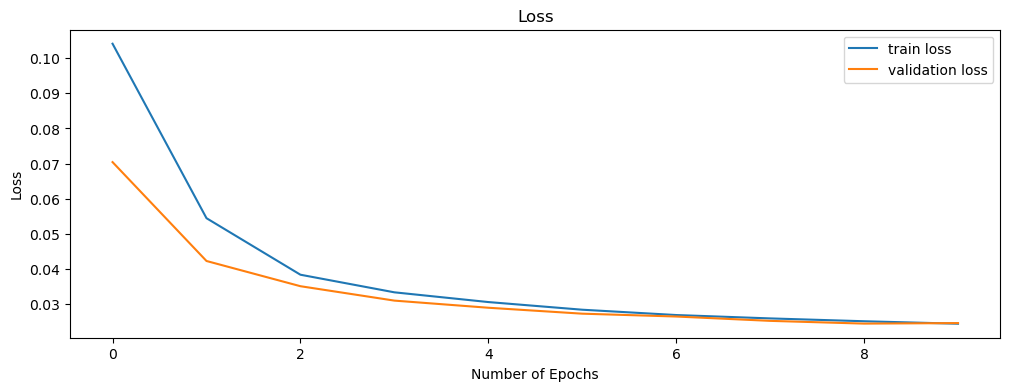

In [68]:
scores_df_denoising = plot_loss(
    history_cnn_complex_sap50, 
    scores_df_denoising, 
    'CNN_Complex_sap50',
)

1/1 [==============================] - 0s 17ms/step


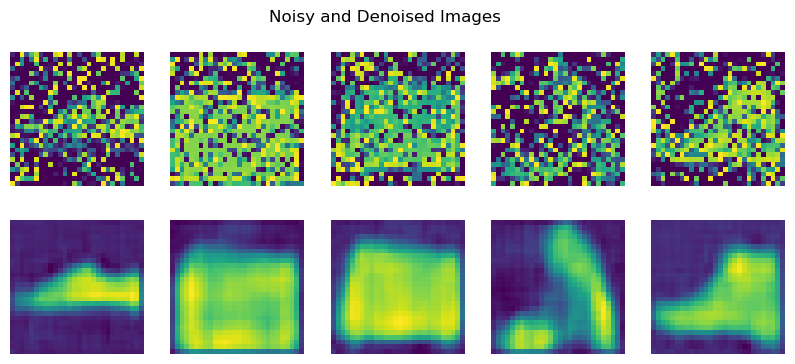

In [69]:
compare_images(val_x_sap50, model_cnn_complex_sap50, TASK)

### <span style="color:#ff5f27">⚙️ Deep AutoEncoder on SAP50</span>

In [70]:
train_x_reshape = train_x.reshape(-1,784)
val_x_reshape = val_x.reshape(-1,784)

train_x_sap50_reshape = train_x_sap50.reshape(-1, 784)
val_x_sap50_reshape = val_x_sap50.reshape(-1, 784)

train_x_cutout_reshape = train_x_cutout.reshape(-1, 784)
val_x_cutout_reshape = val_x_cutout.reshape(-1, 784)

In [71]:
def get_deep_autoencoder():
    reset_seeds()
    input_layer = Input(shape=(28*28,))

    ## encoding architecture
    encode_layer = Dense(512, activation='relu')(input_layer)
    encode_layer = BatchNormalization()(encode_layer)
    encode_layer = Dense(256, activation='relu')(encode_layer)
    encode_layer = BatchNormalization()(encode_layer)
    encode_layer = Dense(128, activation='relu')(encode_layer)

    ## latent view
    latent_view = Dense(10, activation='sigmoid')(encode_layer)

    ## decoding architecture
    decode_layer = Dense(128, activation='relu')(latent_view)
    decode_layer = BatchNormalization()(decode_layer)
    decode_layer = Dense(256, activation='relu')(decode_layer)
    encode_layer = BatchNormalization()(encode_layer)
    decode_layer = Dense(512, activation='relu')(decode_layer)

    ## output layer
    output_layer = Dense(28*28)(decode_layer)

    model = Model(input_layer, output_layer)

    model.compile(
        optimizer='adam',
        loss='mse',
    )
    return model

In [72]:
model_deep_batch_norm_sap50 = get_deep_autoencoder()

history_deep_batch_norm_sap50 = model_deep_batch_norm_sap50.fit(
    train_x_sap50_reshape, 
    train_x_reshape,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_sap50_reshape, val_x_reshape), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.024469276890158653
🎯 Val Accuracy: 0.08518002182245255


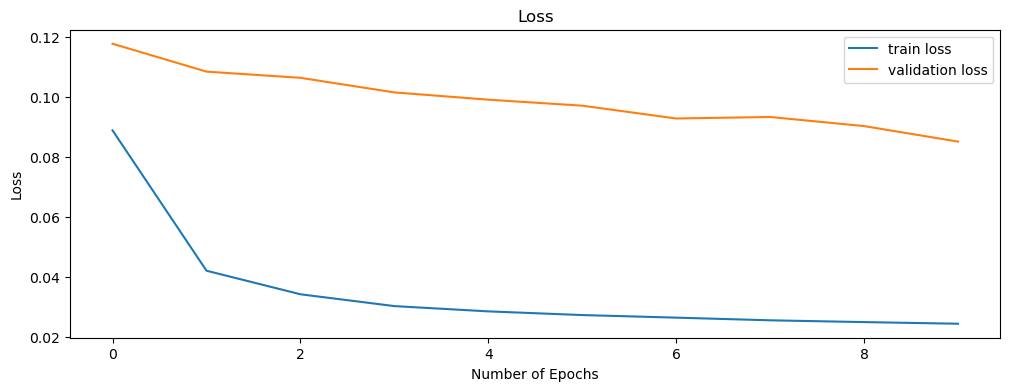

In [73]:
scores_df_denoising = plot_loss(
    history_deep_batch_norm_sap50, 
    scores_df_denoising, 
    'Deep_Batch_Norm_sap50',
)

1/1 [==============================] - 0s 15ms/step


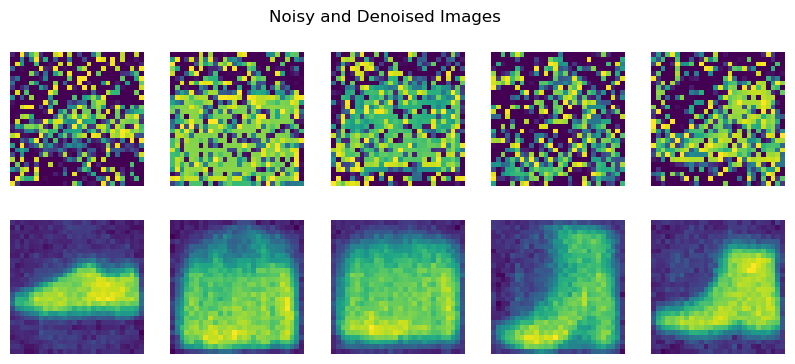

In [74]:
compare_images(val_x_sap50_reshape, model_deep_batch_norm_sap50, TASK)

In [75]:
scores_df_denoising

,model_name,train_loss,val_loss
0,SAP10,0.019866,0.019363
1,SAP25,0.021687,0.021351
2,SAP50,0.026457,0.026014
3,SAP75,0.038499,0.037564
4,Cutout,0.025736,0.025287
5,CNN_Complex_sap50,0.024499,0.024680
6,Deep_Batch_Norm_sap50,0.024469,0.085180


1/1 [==============================] - 0s 16ms/step


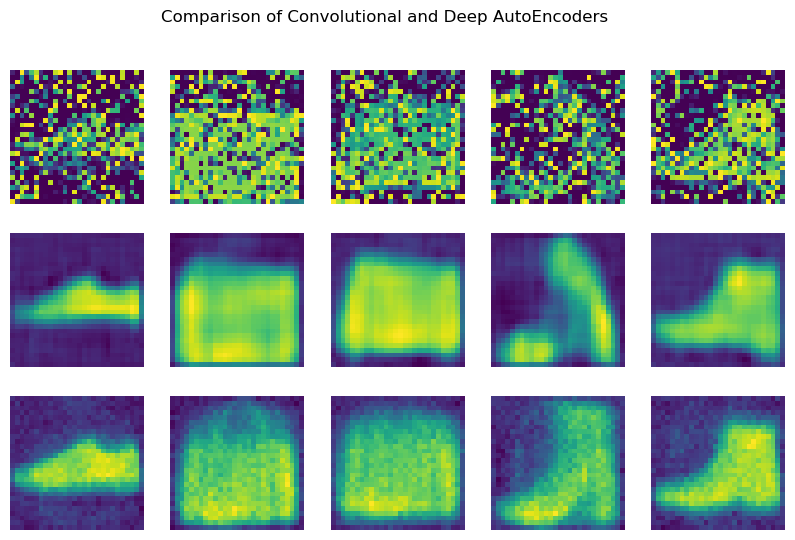

In [76]:
compare_models(val_x_sap50, model_cnn_complex_sap50, model_deep_batch_norm_sap50)

### <span style="color:#ff5f27">⚙️ Convolutional AutoEncoder on Image Cutouts</span>

In [77]:
model_cnn_complex_cutout = get_convolutional_autoencoder()

history_cnn_complex_cutout = model_cnn_complex_cutout.fit(
    train_x_cutout, 
    train_x,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_cutout, val_x), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.02483905479311943
🎯 Val Accuracy: 0.024138199165463448


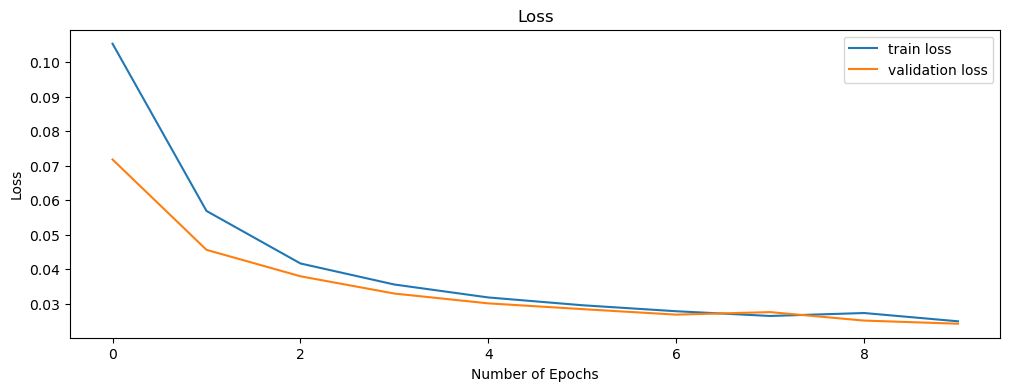

In [78]:
scores_df_denoising = plot_loss(
    history_cnn_complex_cutout, 
    scores_df_denoising, 
    'CNN_Complex_Cutout',
)

1/1 [==============================] - 0s 16ms/step


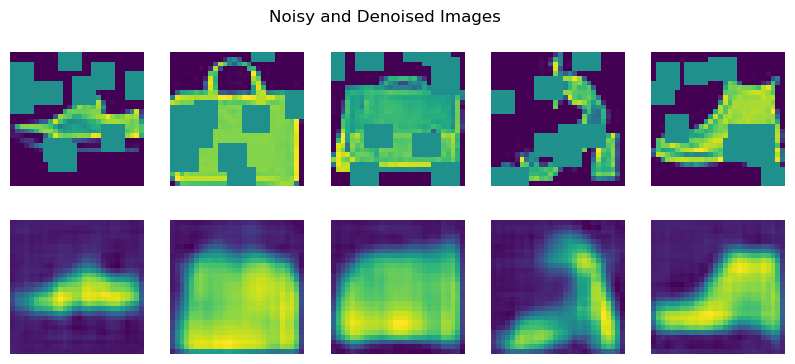

In [79]:
compare_images(val_x_cutout, model_cnn_complex_cutout, TASK)

### <span style="color:#ff5f27">⚙️ Deep AutoEncoder on Image Cutouts</span>

In [80]:
model_deep_batch_norm_cutout = get_deep_autoencoder()

history_deep_batch_norm_cutout = model_deep_batch_norm_cutout.fit(
    train_x_cutout_reshape, 
    train_x_reshape,
    epochs=10, 
    batch_size=2048, 
    validation_data=(val_x_cutout_reshape, val_x_reshape), 
    callbacks=[early_stopping],
    verbose=0,
)

🎯 Train Accuracy: 0.023513803258538246
🎯 Val Accuracy: 0.09782836586236954


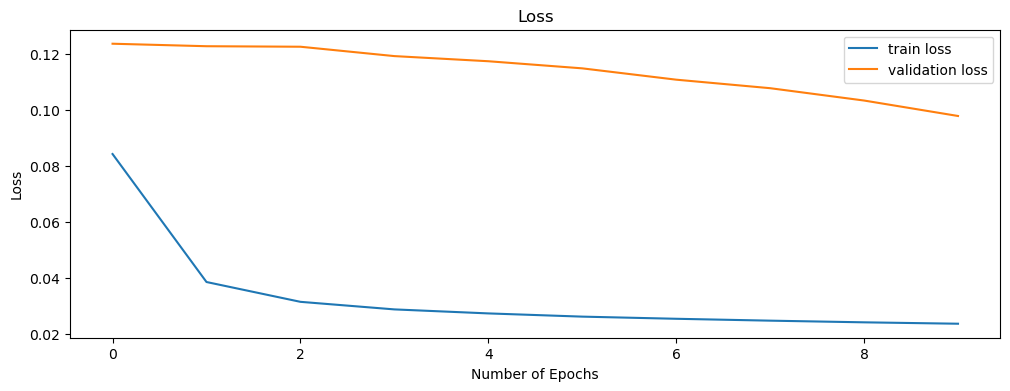

In [81]:
scores_df_denoising = plot_loss(
    history_deep_batch_norm_cutout, 
    scores_df_denoising, 
    'Deep_Batch_Norm_cutout',
)

1/1 [==============================] - 0s 17ms/step


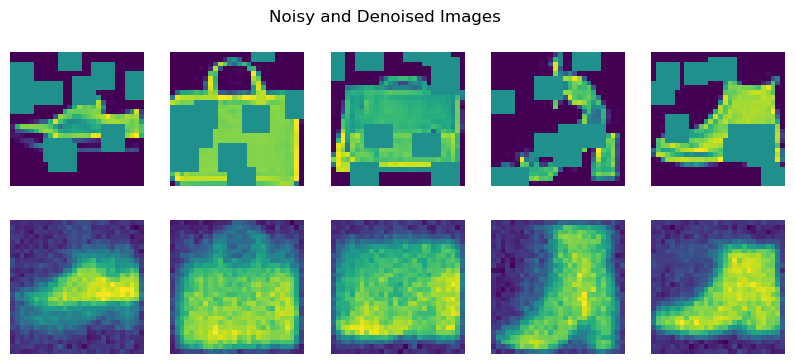

In [82]:
compare_images(val_x_cutout_reshape, model_deep_batch_norm_cutout, TASK)

In [83]:
scores_df_denoising

,model_name,train_loss,val_loss
0,SAP10,0.019866,0.019363
1,SAP25,0.021687,0.021351
2,SAP50,0.026457,0.026014
3,SAP75,0.038499,0.037564
4,Cutout,0.025736,0.025287
5,CNN_Complex_sap50,0.024499,0.024680
6,Deep_Batch_Norm_sap50,0.024469,0.085180
7,CNN_Complex_Cutout,0.024839,0.024138
8,Deep_Batch_Norm_cutout,0.023514,0.097828


1/1 [==============================] - 0s 16ms/step


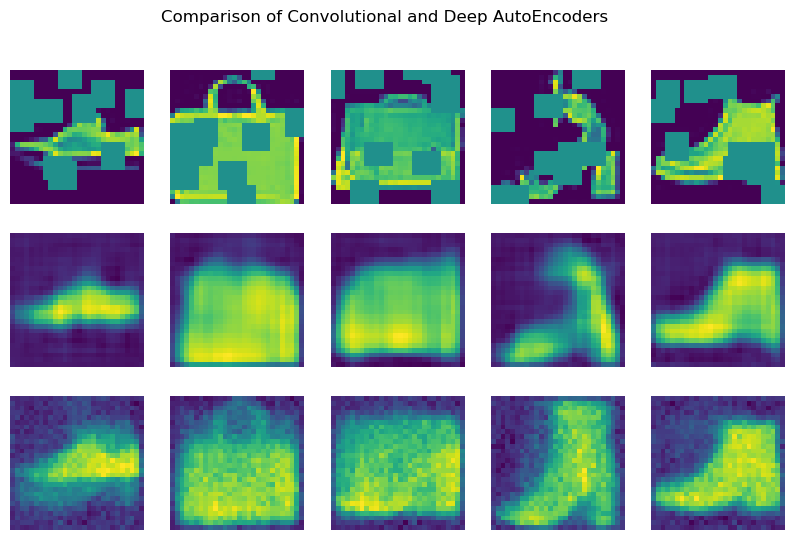

In [84]:
compare_models(val_x_cutout, model_cnn_complex_cutout, model_deep_batch_norm_cutout)

---